This project builds a clustering-based product recommender system using user ratings and unsupervised learning techniques. It compares KMeans, Hierarchical, and DBSCAN models to group similar users and suggest top-rated products within each cluster.

In [29]:
import pandas as pd

df = pd.read_csv("rating_short.csv", header=None)
df.columns = ['userId', 'productId', 'rating', 'timestamp']

df.head()

,userId,productId,rating,timestamp
0,userid,productid,rating,date
1,A1Z3YJF1S8Z1M3,B000M9ISQ2,5.0,1199750400
2,ALDXDYEGKB27G,B002L6HE9G,4.0,1331337600
3,A15LOGO6NBSI6B,B007MXGG5Q,5.0,1358640000
4,A23LX12CA3G4FG,B008HOEDYU,1.0,1385337600


Loads the raw ratings dataset and assigns meaningful column names. The header is manually defined since the file lacks one

In [30]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78246 entries, 0 to 78245
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     78246 non-null  object
 1   productId  78246 non-null  object
 2   rating     78246 non-null  object
 3   timestamp  78246 non-null  object
dtypes: object(4)
memory usage: 2.4+ MB


,userId,productId,rating,timestamp
count,78246,78246,78246,78246
unique,76431,40229,6,4069
top,A3LGT6UZL99IW1,B0074BW614,5.0,1389052800
freq,8,201,43360,201


In [31]:
if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)

Removes the timestamp column as it's not needed for clustering or recommendations. Keeps the dataset focused on user-product interactions

In [32]:
print("Shape of dataset:", df.shape)

Shape of dataset: (78246, 3)


In [33]:
df.columns

Index(['userId', 'productId', 'rating'], dtype='object')

In [34]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 userId       0
productId    0
rating       0
dtype: int64


In [35]:
df['rating'].describe()

,rating
count,78246
unique,6
top,5.0
freq,43360


In [36]:
print("\nDescriptive stats for ratings:\n", df['rating'].describe())


Descriptive stats for ratings:
 count     78246
unique        6
top         5.0
freq      43360
Name: rating, dtype: object


In [37]:
print("Total unique users:", df['userId'].nunique())
print("Total unique products:", df['productId'].nunique())

Total unique users: 76431
Total unique products: 40229


Displays dataset shape, missing values, rating distribution, and counts of unique users/products. Helps assess data quality and scale

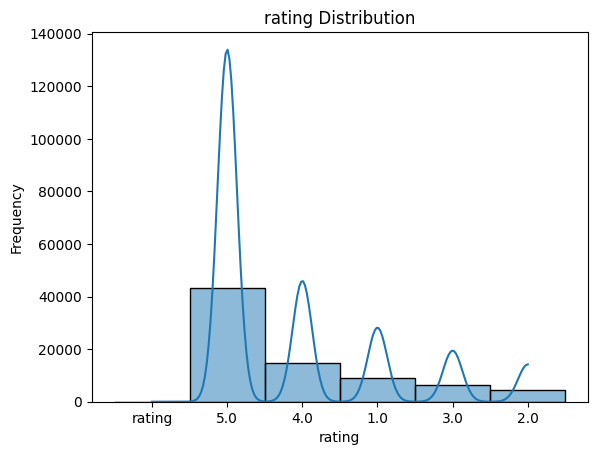

In [38]:
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('rating Distribution')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.show()

Plots the distribution of ratings to understand user behavior. Reveals skewness or concentration in rating values

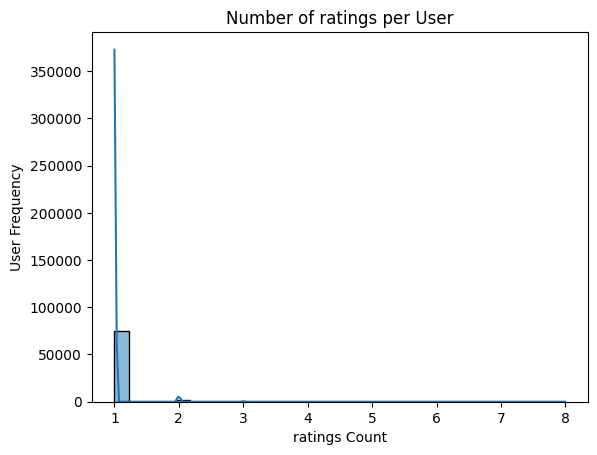

In [39]:
user_counts = df['userId'].value_counts()
sns.histplot(user_counts, bins=30, kde=True)
plt.title('Number of ratings per User')
plt.xlabel('ratings Count')
plt.ylabel('User Frequency')
plt.show()

Shows how many ratings each user has given. Helps identify active vs. inactive users.

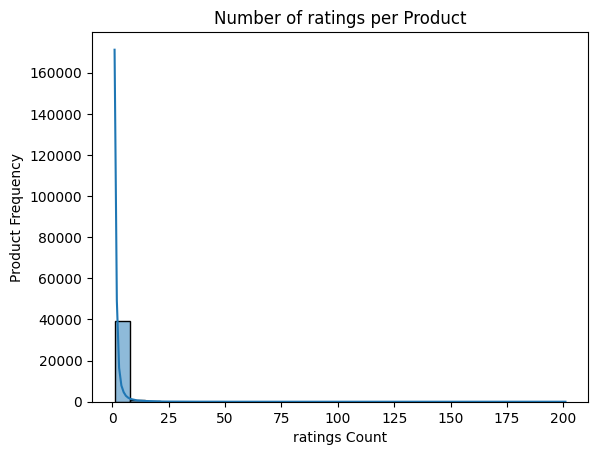

In [40]:
product_counts = df['productId'].value_counts()
sns.histplot(product_counts, bins=30, kde=True)
plt.title('Number of ratings per Product')
plt.xlabel('ratings Count')
plt.ylabel('Product Frequency')
plt.show()

Visualizes how frequently each product is rated. Useful for spotting popular or niche items.




In [41]:
df_sample = df.sample(n=10000, random_state=42)
print("Sampled Data Shape:", df_sample.shape)

Sampled Data Shape: (10000, 3)


Samples 10,000 rows for faster processing. Converts rating strings to numeric values for analysis

In [42]:
df_sample['rating'] = pd.to_numeric(df_sample['rating'], errors='coerce')

In [43]:
user_product_matrix = df_sample.pivot_table(index='userId',
                                            columns='productId',
                                            values='rating').fillna(0)
print("User–Product Matrix Shape:", user_product_matrix.shape)

User–Product Matrix Shape: (9973, 8021)


Creates a matrix of users vs. products with ratings. Missing ratings are filled with 0 to enable clustering

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_product_matrix)

# Reduce dimensionality using PCA (to speed up clustering)
pca = PCA(n_components=30, random_state=42)
reduced_data = pca.fit_transform(scaled_data)
print("Reduced Data Shape:", reduced_data.shape)

Reduced Data Shape: (9973, 30)


Standardizes the matrix and reduces dimensions using PCA. Improves clustering performance and reduces noise

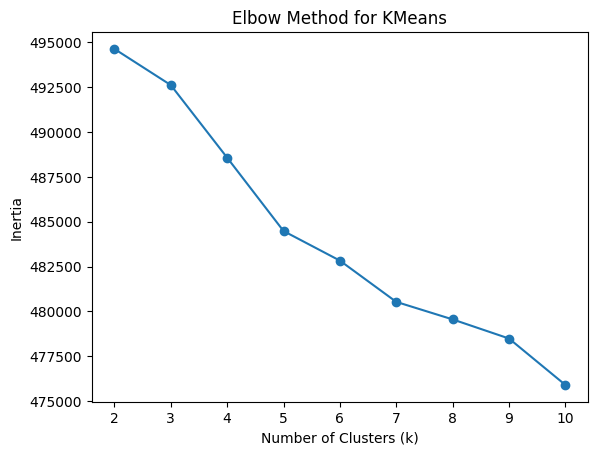

In [45]:
#  KMeans Clustering
inertia = []
for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

Tests multiple cluster sizes to find the optimal number. The elbow plot helps visualize the best value for k

In [46]:
# Choose optimal k (e.g., 5)
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=512)
kmeans_labels = kmeans.fit_predict(reduced_data)
user_product_matrix['Cluster_KMeans'] = kmeans_labels

print("KMeans Silhouette Score:",
      silhouette_score(reduced_data, kmeans_labels))

KMeans Silhouette Score: 0.04057873815815568


Applies KMeans with chosen k=5 and stores cluster labels. Groups users based on their rating patterns.

Calculates silhouette score to evaluate clustering quality. Higher scores indicate better-defined clusters

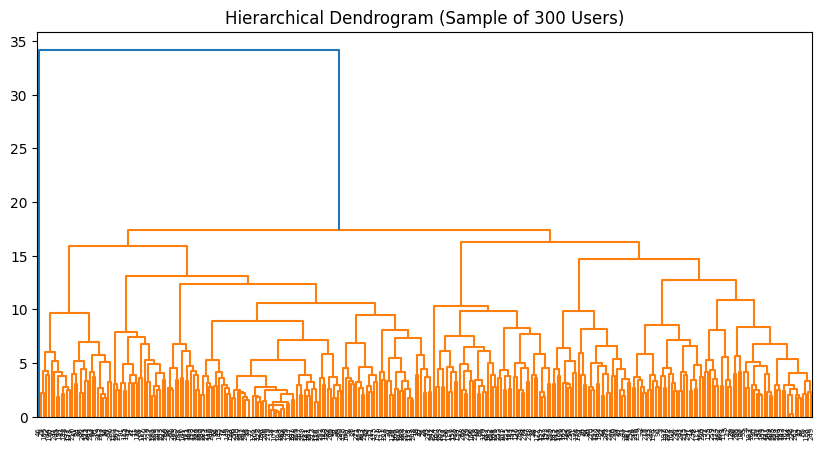

In [47]:
#  Hierarchical Clustering (on small sample)
sample_idx = np.random.choice(range(reduced_data.shape[0]), size=300, replace=False)
sample_data = reduced_data[sample_idx]

linkage_matrix = linkage(sample_data, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Dendrogram (Sample of 300 Users)")
plt.show()

Generates a dendrogram for a sample of users. Visualizes hierarchical relationships between user clusters

In [48]:
 #Apply Agglomerative Clustering on reduced data
hc = AgglomerativeClustering(n_clusters=5, linkage='ward')
hc_labels = hc.fit_predict(reduced_data)
user_product_matrix['Cluster_HC'] = hc_labels

print("Hierarchical Silhouette Score:",
      silhouette_score(reduced_data, hc_labels))

Hierarchical Silhouette Score: 0.9646249464190358


Applies hierarchical clustering to all users. Adds cluster labels to the matrix for comparison.

Evaluates hierarchical clustering using silhouette score. Helps compare with KMeans and DBSCAN.

In [49]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

best_eps = None
best_score = -1
best_labels = None

# Try a few eps values to find at least 2 clusters
for eps in [0.3, 0.5, 1, 1.5, 2, 3]:
    dbscan = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
    db_labels = dbscan.fit_predict(reduced_data)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

    if n_clusters > 1:
        mask = db_labels != -1
        if mask.sum() > 1:
            score = silhouette_score(reduced_data[mask], db_labels[mask])
            print(f"eps={eps}: clusters={n_clusters}, silhouette={score:.3f}")
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = db_labels
        else:
            print(f"eps={eps}: too few valid samples for silhouette score.")
    else:
        print(f"eps={eps}: only {n_clusters} cluster(s) formed, skipping.")

if best_labels is not None:
    print(f"\n Best DBSCAN found at eps={best_eps} with silhouette={best_score:.3f}")
    user_product_matrix['Cluster_DBSCAN'] = best_labels
else:
    print("\n DBSCAN could not form valid clusters with any eps value. Skipping DBSCAN analysis.")


eps=0.3: clusters=48, silhouette=0.845
eps=0.5: clusters=54, silhouette=0.524
eps=1: clusters=16, silhouette=0.077
eps=1.5: clusters=6, silhouette=0.106
eps=2: clusters=4, silhouette=0.167
eps=3: clusters=2, silhouette=0.449

 Best DBSCAN found at eps=0.3 with silhouette=0.845


Tests multiple eps values to find the best DBSCAN configuration. Filters out poor clustering attempts.

Stores the best DBSCAN labels if valid clusters are found. Adds them to the matrix for model comparison.

In [50]:
model_scores = {
    'KMeans': silhouette_score(reduced_data, user_product_matrix['Cluster_KMeans']),
    'Hierarchical': silhouette_score(reduced_data, user_product_matrix['Cluster_HC']),
    'DBSCAN': best_score
}
print(pd.DataFrame(model_scores.items(), columns=['Model','Silhouette_Score']))


          Model  Silhouette_Score
0        KMeans          0.040579
1  Hierarchical          0.964625
2        DBSCAN          0.845313


Compares clustering models using silhouette scores. Displays results in a clean table format

As Hierarchial Clustering has the highest Silhouette Score, It is the best model for product recommendation.

In [51]:
def recommend_products(user_id, cluster_label_col='Cluster_HC'):
    # Check if user exists
    if user_id not in user_product_matrix.index:
        return "User ID not found in the data sample."

    # Get user's cluster
    user_cluster = user_product_matrix.loc[user_id, cluster_label_col]

    # Get all users in that cluster
    cluster_users = user_product_matrix[user_product_matrix[cluster_label_col] == user_cluster]

    # Drop cluster columns
    cluster_users = cluster_users.drop(columns=['Cluster_KMeans', 'Cluster_HC', 'Cluster_DBSCAN'], errors='ignore')

    # Calculate average product ratings in that cluster
    mean_ratings = cluster_users.mean().sort_values(ascending=False)

    # Return top 5 recommended products
    top_products = mean_ratings.head(5)
    return top_products

# Example: Recommend for one random user
sample_user = user_product_matrix.index[0]
print(f"\nTop recommended products for user {sample_user}:")
print(recommend_products(sample_user, cluster_label_col='Cluster_HC'))



Top recommended products for user A0009478CBXKUCALUC7U:
productId
B0074BW614    0.011141
B007WTAJTO    0.010138
B0019EHU8G    0.009937
B00622AG6S    0.008431
B007R5YDYA    0.007729
dtype: float64


Defines a function to recommend top products for a user. Uses cluster-based average ratings for suggestions.

Generates recommendations for one sample user. Demonstrates how the function works using hierarchical clusters.